In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from matplotlib import pyplot as plt

from channel import DropPolarization, PolarizationRotation, Splitter, SSFChannel
from filters import AdaptiveEqualizerAlamouti, CDCompensator, Decimate, PulseFilter
from laser import ContinuousWaveLaser, NoisyLaser
from modulation import (
    AlamoutiEncoder,
    Demodulator16QAM,
    DemodulatorQPSK,
    DPModulator,
    Modulator16QAM,
    ModulatorQPSK,
)
from receiver import NoisyOpticalFrontEnd, OpticalFrontEnd

In [4]:
CHANNEL_SPS = 16
RECEIVER_SPS = 2
# At Eb/N0 = 10 dB, we need around 49 taps at 25 km, 79 taps at 50 km, and 143
# taps at 100 km. However, we can go up to 2**n - 1 without increasing the
# overlap-save frame size, which should be strictly better.
CDC_TAPS = 63
FIBRE_LENGTH = 25_000  # 25 km
SPLITTING_POINT = 24_000  # 24 km
CONSUMERS = 16 # XXX
SYMBOL_RATE = 50 * 10**9  # 50 GS/s
TARGET_BER = 0.5 * 10**-3
DDPR_BUFFER_SIZE = 64
LASER_LINEWIDTH_ESTIMATE = 100e3  # 100 kHz
SNR_ESTIMATE = 10  # 10 dB
# Paper uses 60,000 QPSK training symbols
LENGTH = PulseFilter.symbols_for_total_length(2**21) # almost 2 M
# XXX Need a multiple of 4 for Alamouti coding
SYMBOLS_PER_BLOCK = LENGTH & ~0b11 

In [5]:
def plot_signal(signal: np.ndarray) -> None:
    assert signal.ndim == 1
    assert signal.size > 0

    signal = signal[:8192]

    s_real = np.real(signal)
    s_imag = np.imag(signal)

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 6))

    # Constellation diagram.
    ax = axs[0][0]
    ax.scatter(s_real, s_imag, alpha=0.05)
    ax.axis("equal")
    ax.set_xlabel("In-phase")
    ax.set_ylabel("Quadrature")
    ax.axhline(color="black")
    ax.axvline(color="black")

    # Unused plot.
    axs[1][0].set_axis_off()

    # Signal (real component).
    ax = axs[0][1]
    ax.stem(s_real)
    ax.set_xlim(-4, 128)
    ax.set_xlabel("Sample")
    ax.set_ylabel("In-phase")

    # Signal (imaginary component).
    ax = axs[1][1]
    ax.stem(s_imag)
    ax.set_xlim(-4, 128)
    ax.set_xlabel("Sample")
    ax.set_ylabel("Quadrature")

    # Spectrum.
    axs[0][2].magnitude_spectrum(signal.tolist(), sides="twosided")
    axs[1][2].phase_spectrum(signal.tolist(), sides="twosided")

    fig.tight_layout()

    plt.show()

In [6]:
print(SYMBOLS_PER_BLOCK, LENGTH)

2097080 2097083


In [7]:
data = np.random.randint(0, 2, SYMBOLS_PER_BLOCK * 4, np.bool_)
tx_mod = Modulator16QAM()(data)

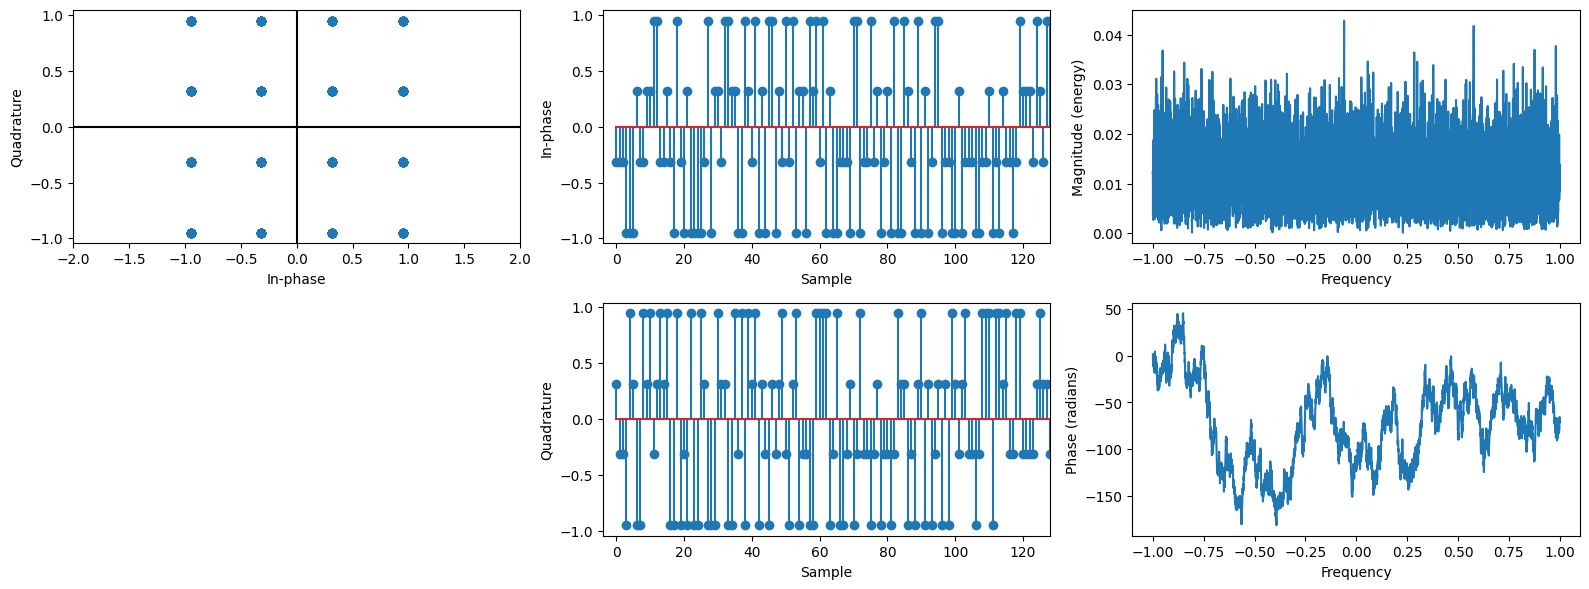

In [8]:
plot_signal(tx_mod)

In [9]:
# Alamouti encoding. 2 polarizations.
tx_alamouti = AlamoutiEncoder()(tx_mod)

In [10]:
# plot_signal(tx_alamouti[0])
# plot_signal(tx_alamouti[1])

In [11]:
tx_alamouti.shape

(2, 2097080)

In [12]:
tx_mod.shape

(2097080,)

In [13]:
tx_pf = PulseFilter(CHANNEL_SPS, up=CHANNEL_SPS)(np.pad(tx_alamouti, ((0, 0), (0, LENGTH - SYMBOLS_PER_BLOCK))))

In [14]:
tx_pf.shape

(2, 33554432)

In [15]:
from utils import is_power_of_2

assert is_power_of_2(tx_pf.shape[1])

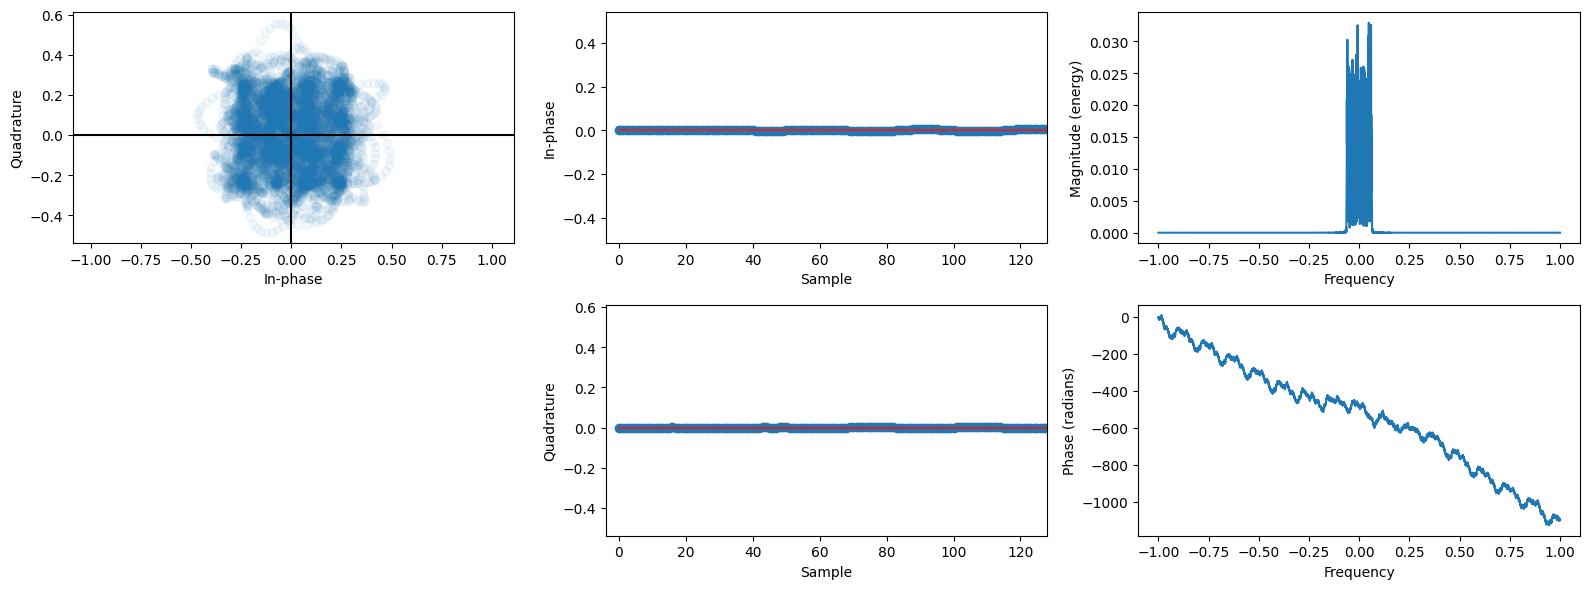

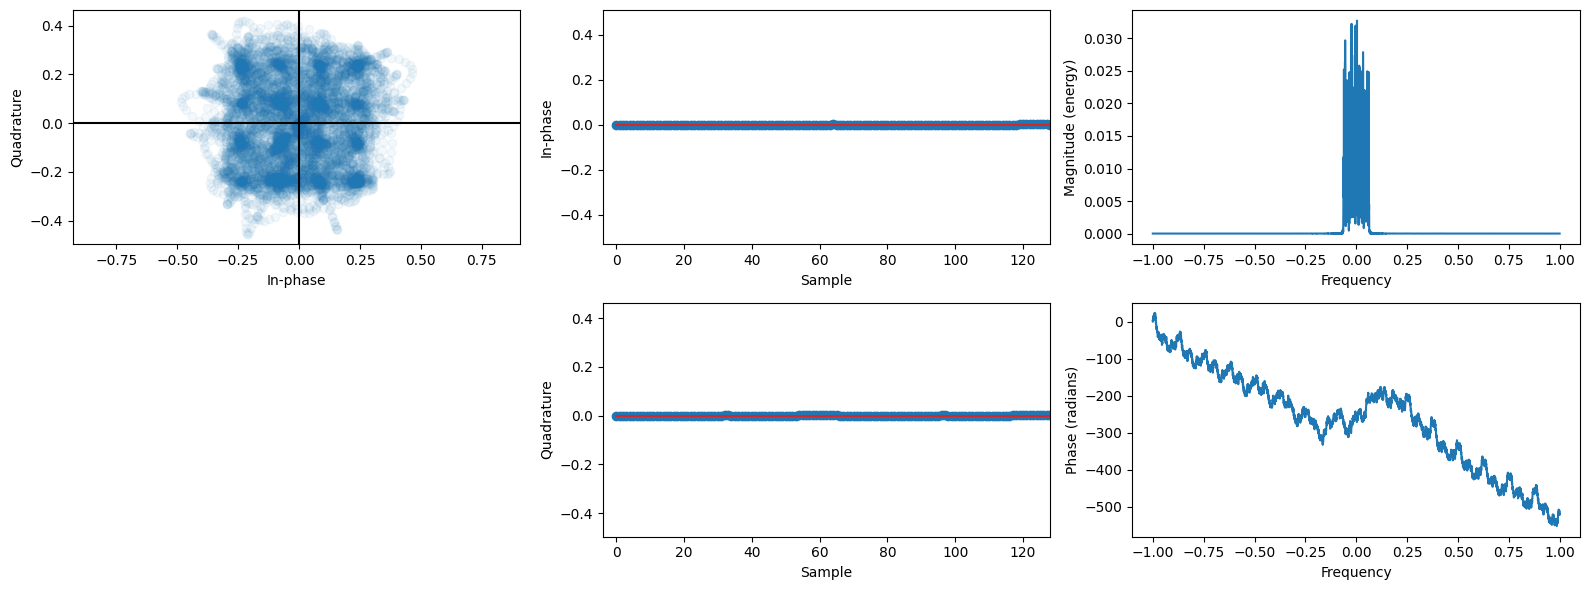

In [16]:
plot_signal(tx_pf[0])
plot_signal(tx_pf[1])

In [17]:
laser = NoisyLaser(8, SYMBOL_RATE * CHANNEL_SPS)
tx_txd = DPModulator(laser)(tx_pf)

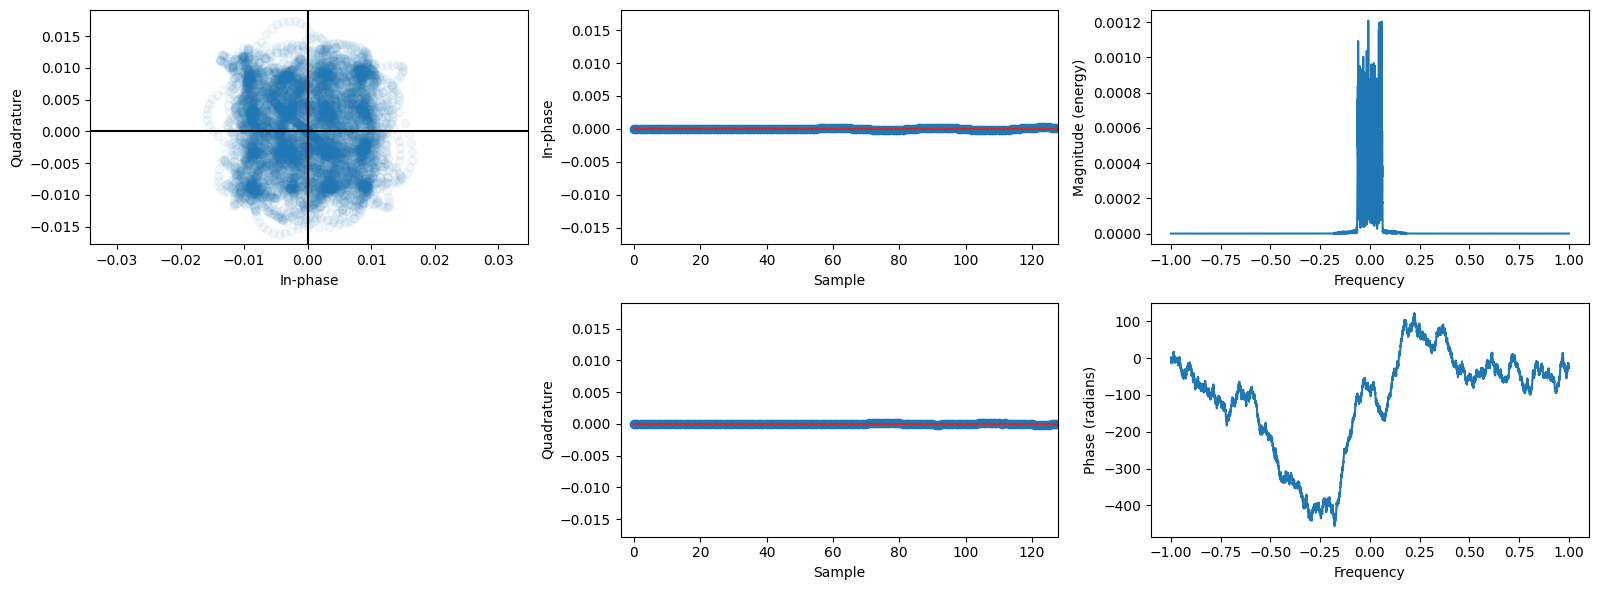

In [18]:
plot_signal(tx_txd[0])

In [19]:
tx_txd.size // 2

33554432

In [20]:
# ch_1 = SSFChannel(SPLITTING_POINT, SYMBOL_RATE * CHANNEL_SPS)(tx_txd)
# ch_s = Splitter(CONSUMERS)(ch_1)
# ch_2 = SSFChannel(FIBRE_LENGTH - SPLITTING_POINT, SYMBOL_RATE * CHANNEL_SPS)(ch_s)

In [21]:
ch_rot = PolarizationRotation(np.pi/3)(tx_txd)
ch_one = DropPolarization()(ch_rot)

In [22]:
rx_fe = NoisyOpticalFrontEnd(SYMBOL_RATE * CHANNEL_SPS)(ch_one)

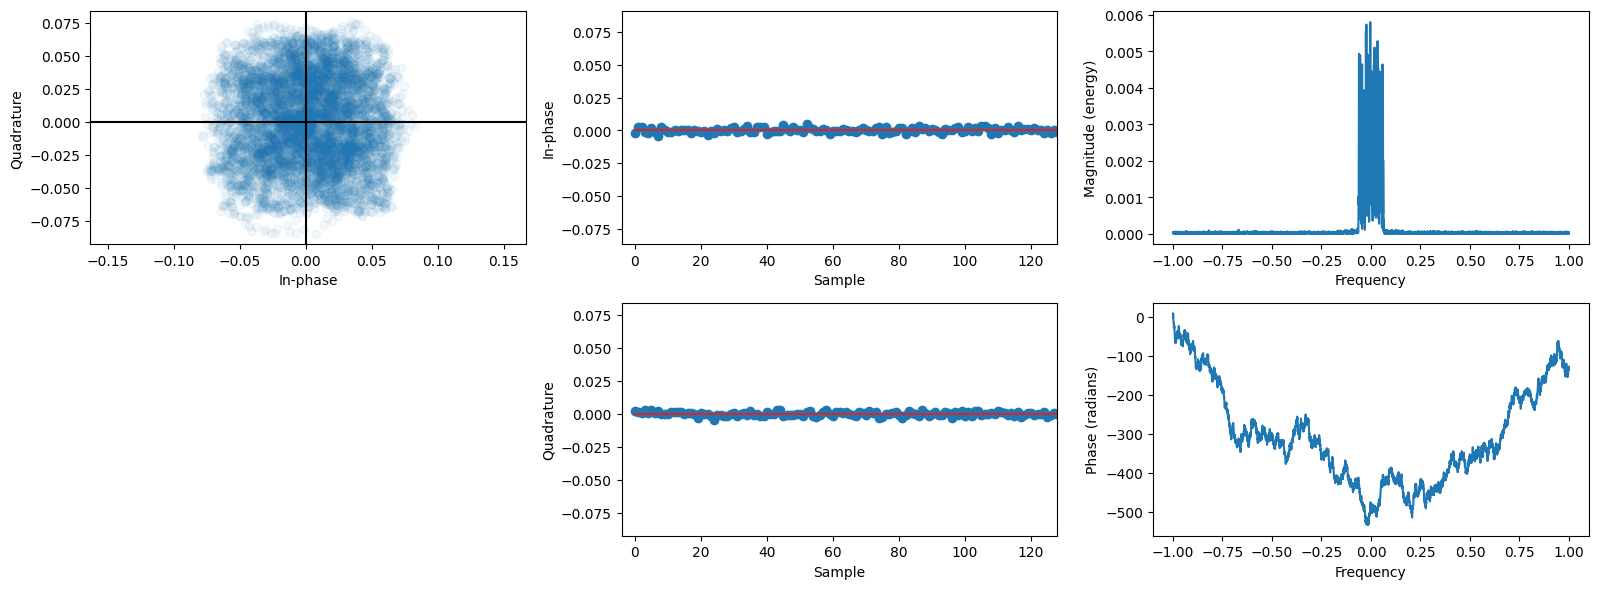

In [23]:
plot_signal(rx_fe)

In [24]:
rx_down = Decimate(CHANNEL_SPS // RECEIVER_SPS)(rx_fe)

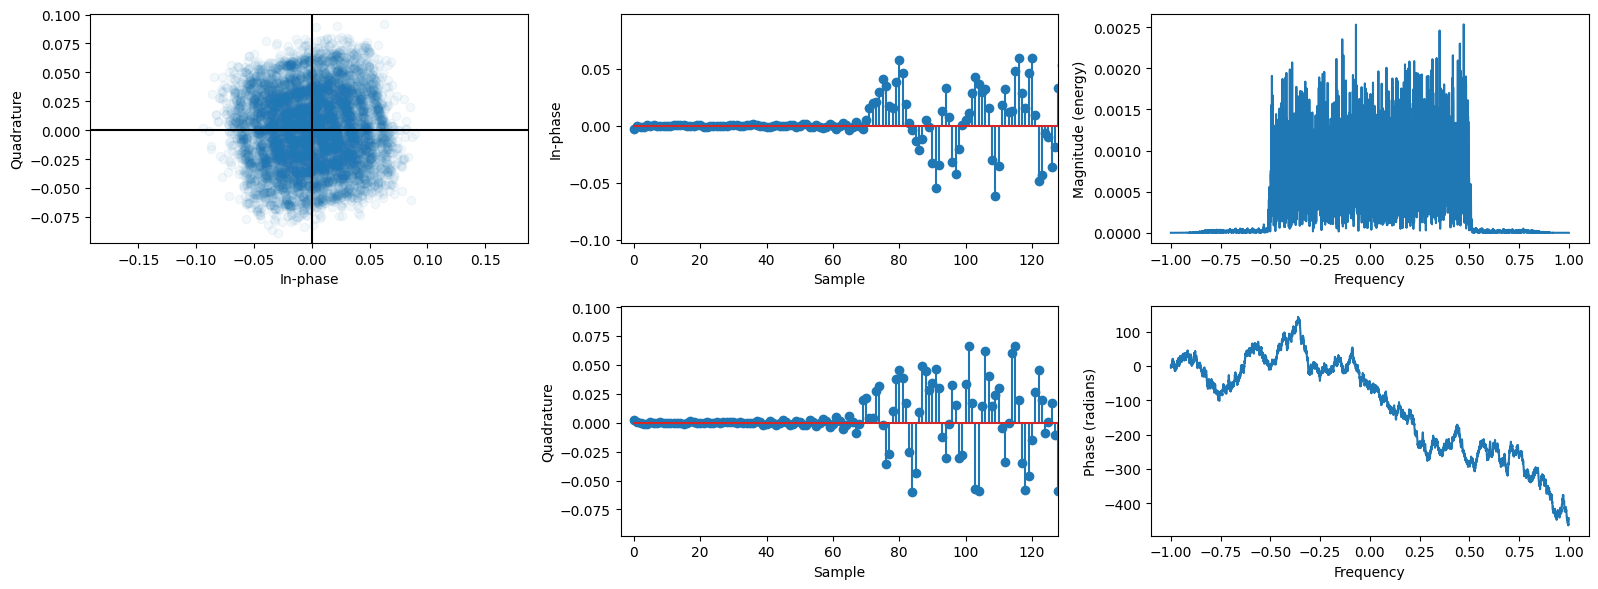

In [25]:
plot_signal(rx_down)

In [26]:
# rx_cdc = CDCompensator(FIBRE_LENGTH, SYMBOL_RATE * RECEIVER_SPS, RECEIVER_SPS, CDC_TAPS)(rx_down)

In [27]:
# plot_signal(rx_cdc)

In [28]:
# rx_cdc.shape

In [29]:
rx_pf = PulseFilter(RECEIVER_SPS, down=RECEIVER_SPS)(rx_down)[:-3]

In [30]:
rx_pf.shape

(2097080,)

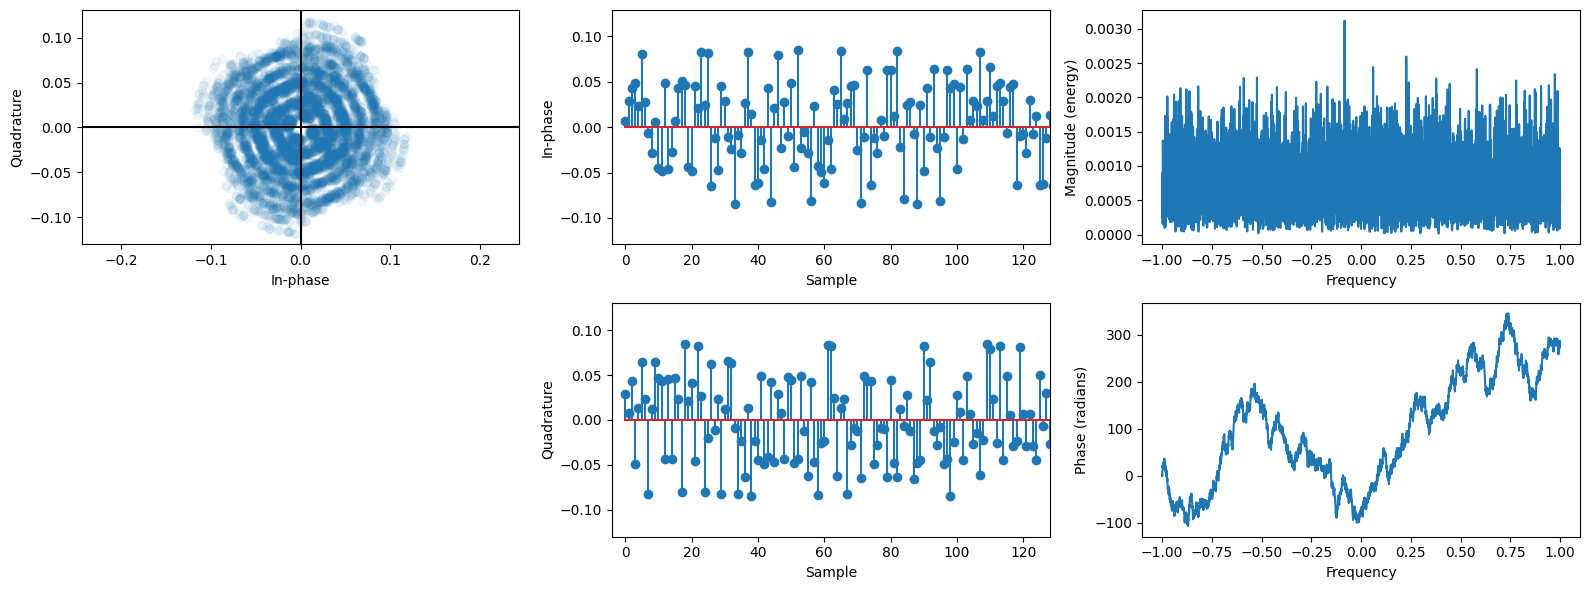

In [31]:
plot_signal(rx_pf)

In [32]:
from utils import signal_power

print(signal_power(tx_mod))
print(signal_power(rx_pf))

1.0001365708508971
0.004172962031496493


In [33]:
# Upper bound on mu
2 / (17 * signal_power(rx_pf)**2)

6756.0399323084375

In [160]:
# 17, 1e-5, 1e-2
aeq = AdaptiveEqualizerAlamouti(17, 1e-4, 1e-2, Modulator16QAM(), Demodulator16QAM(), tx_mod)
rx_aeq = aeq(rx_pf)

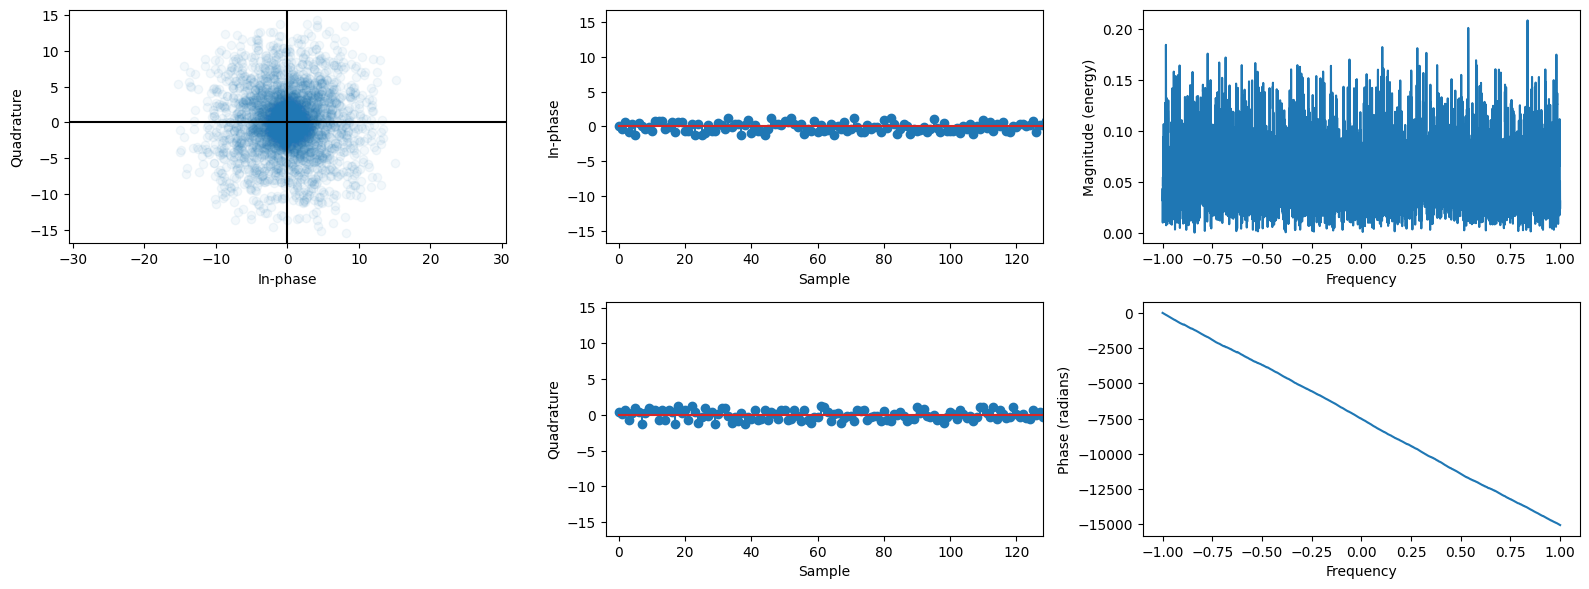

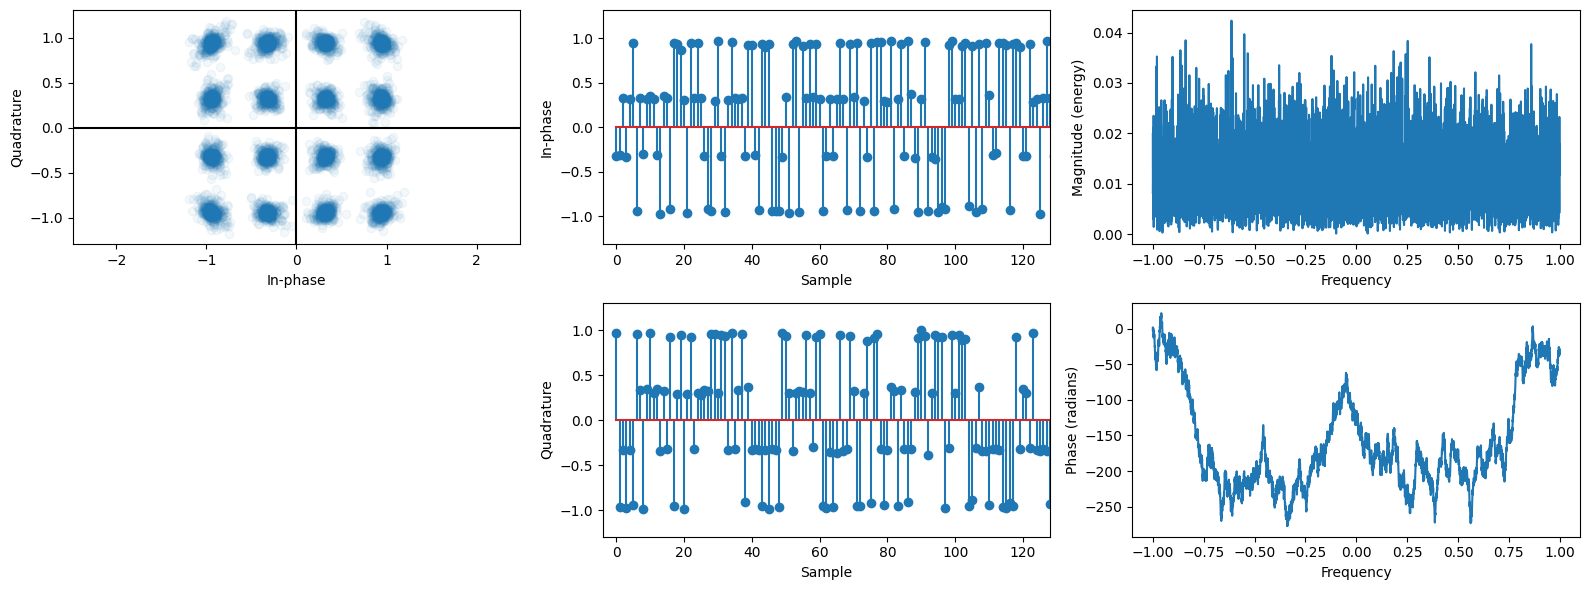

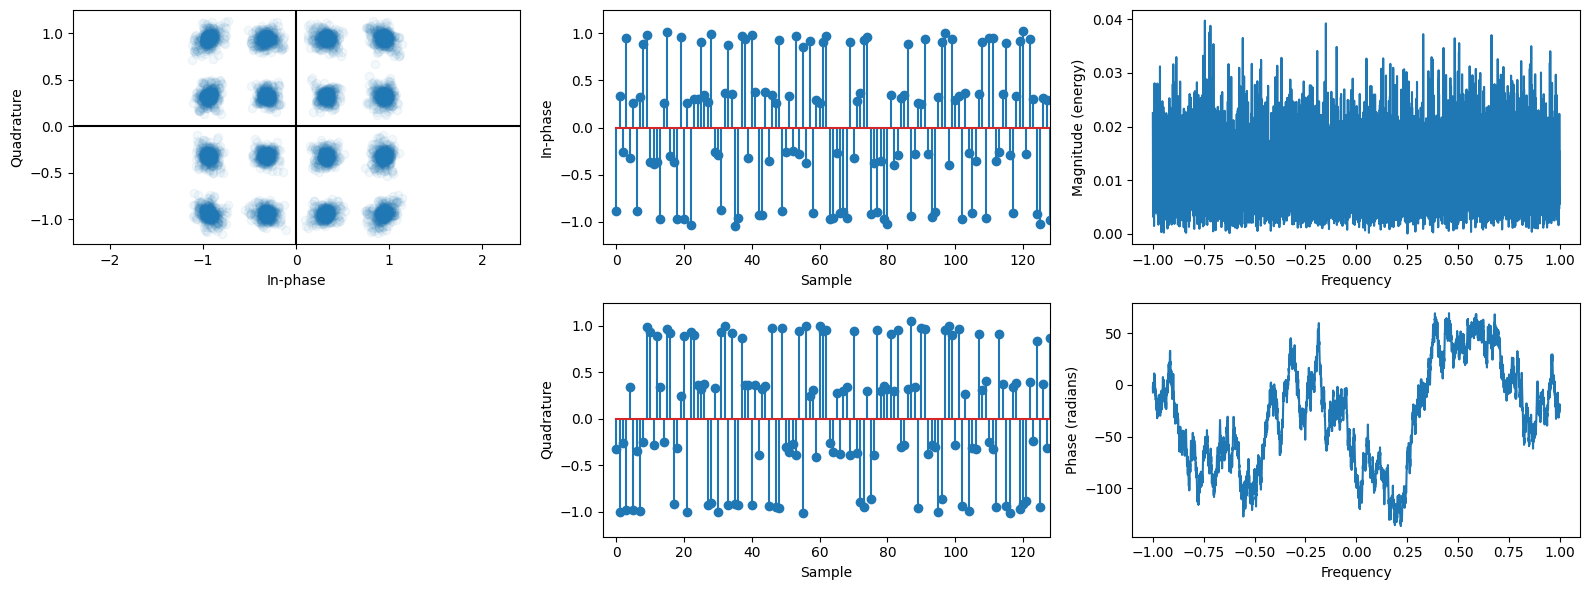

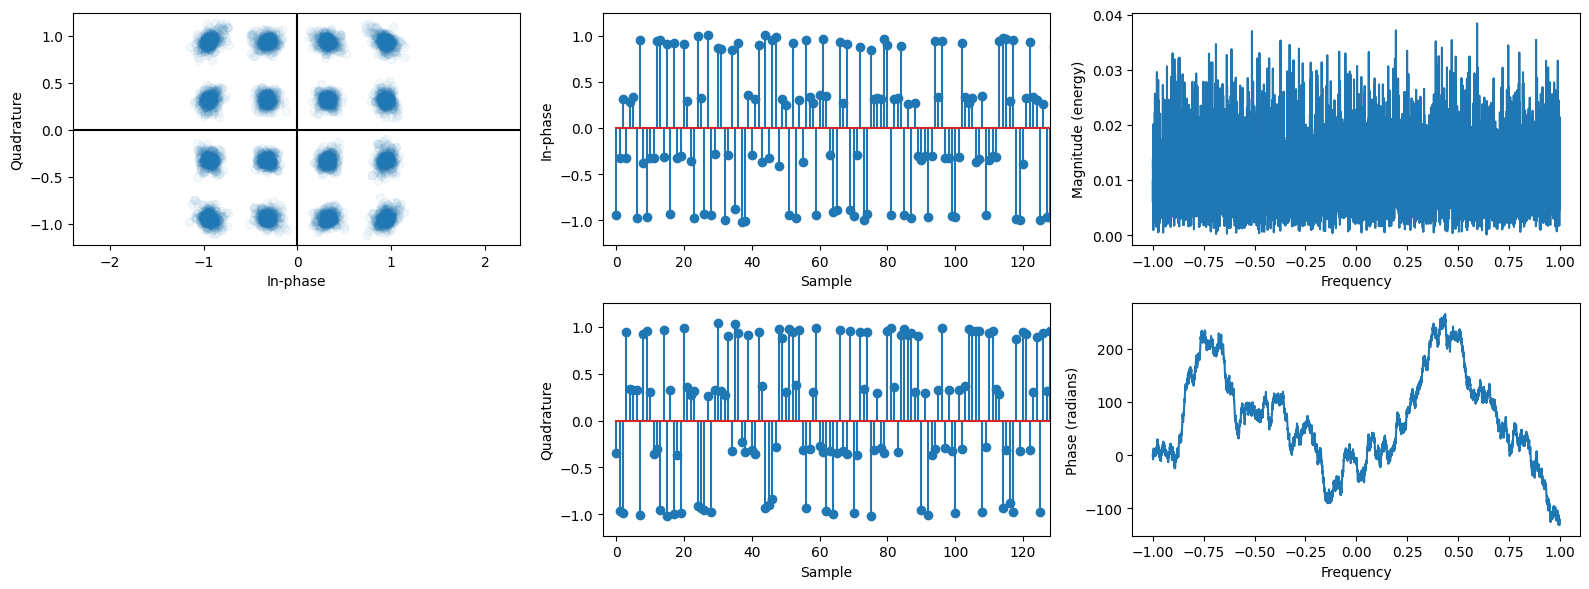

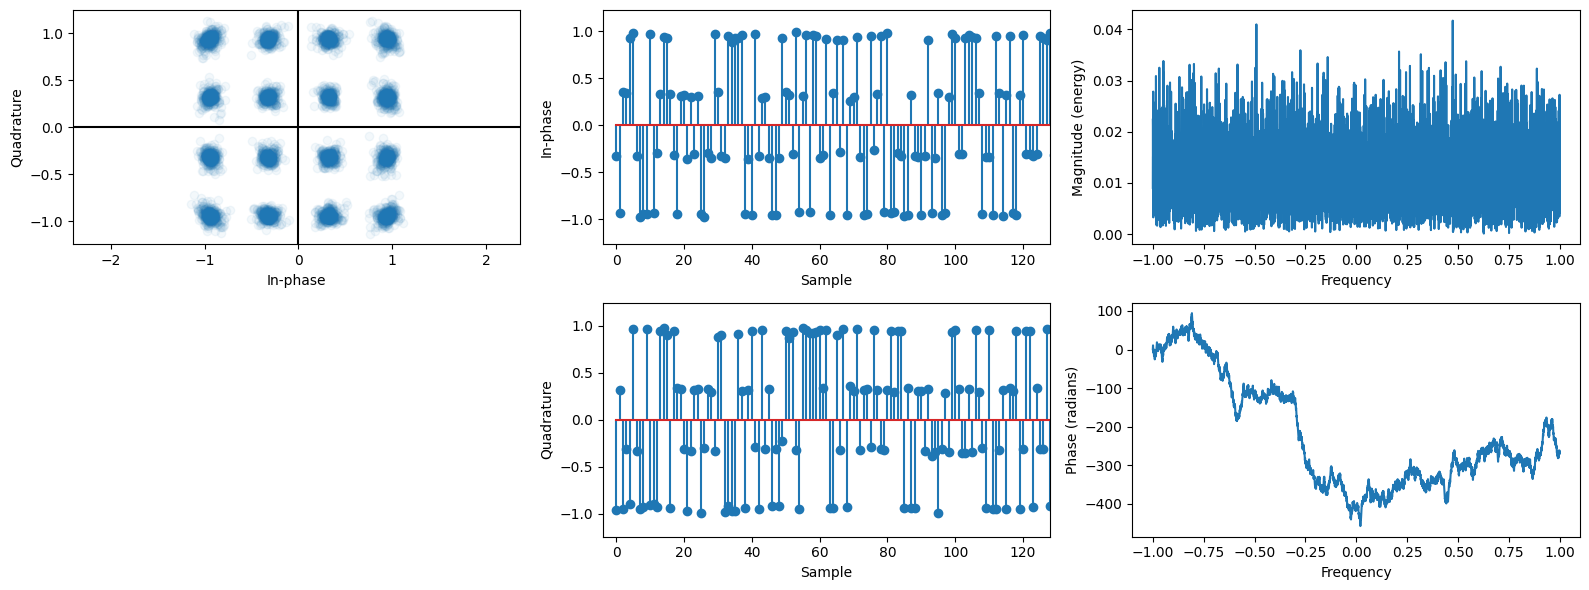

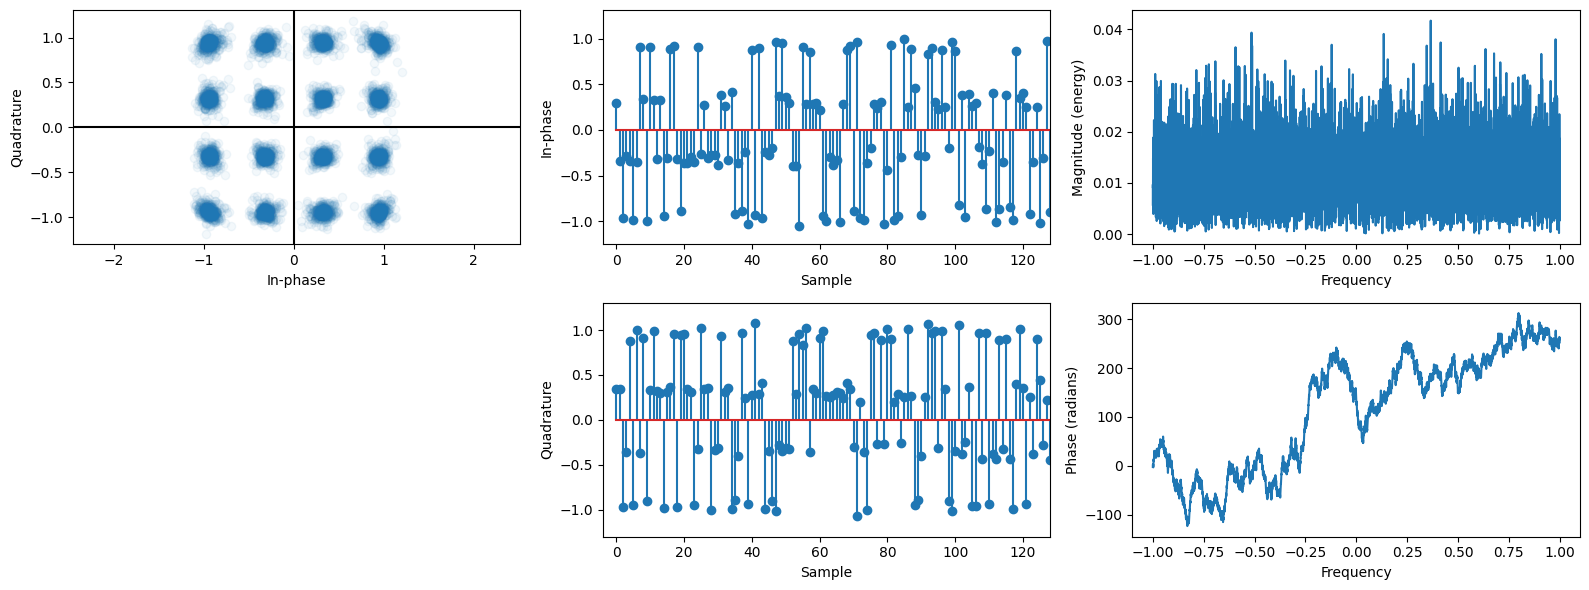

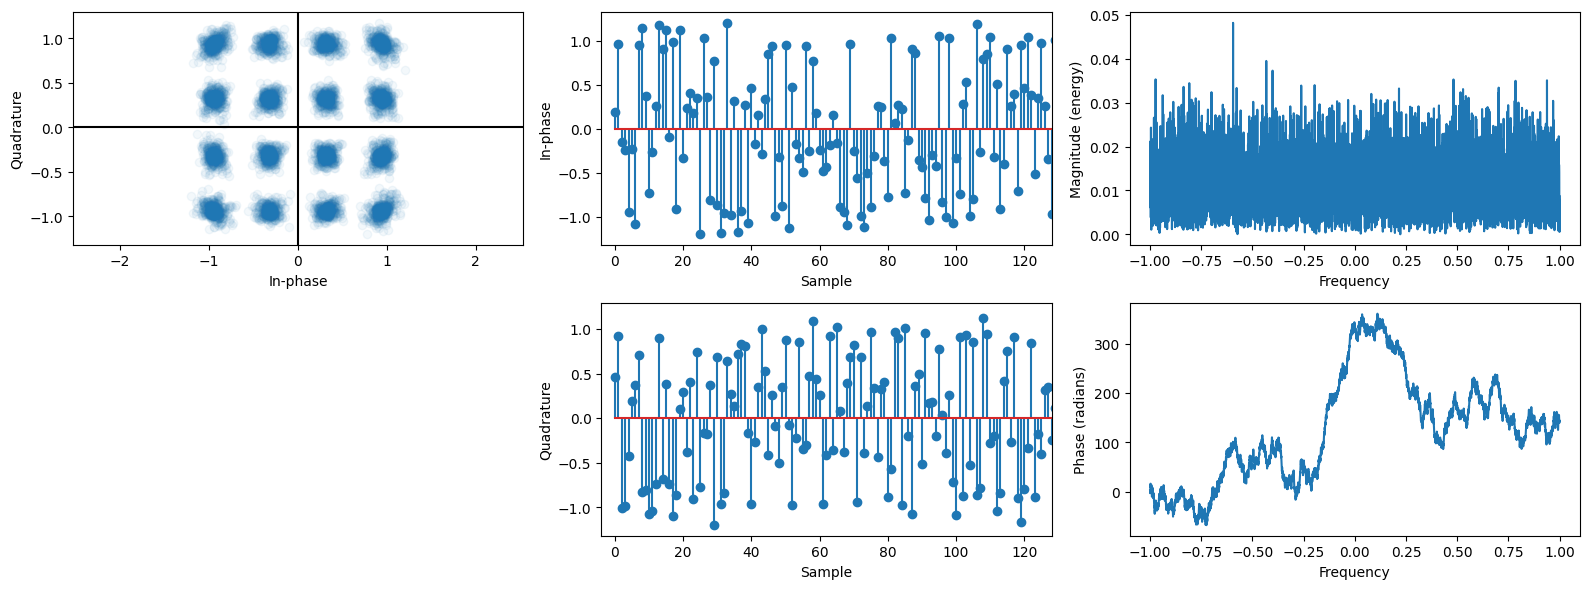

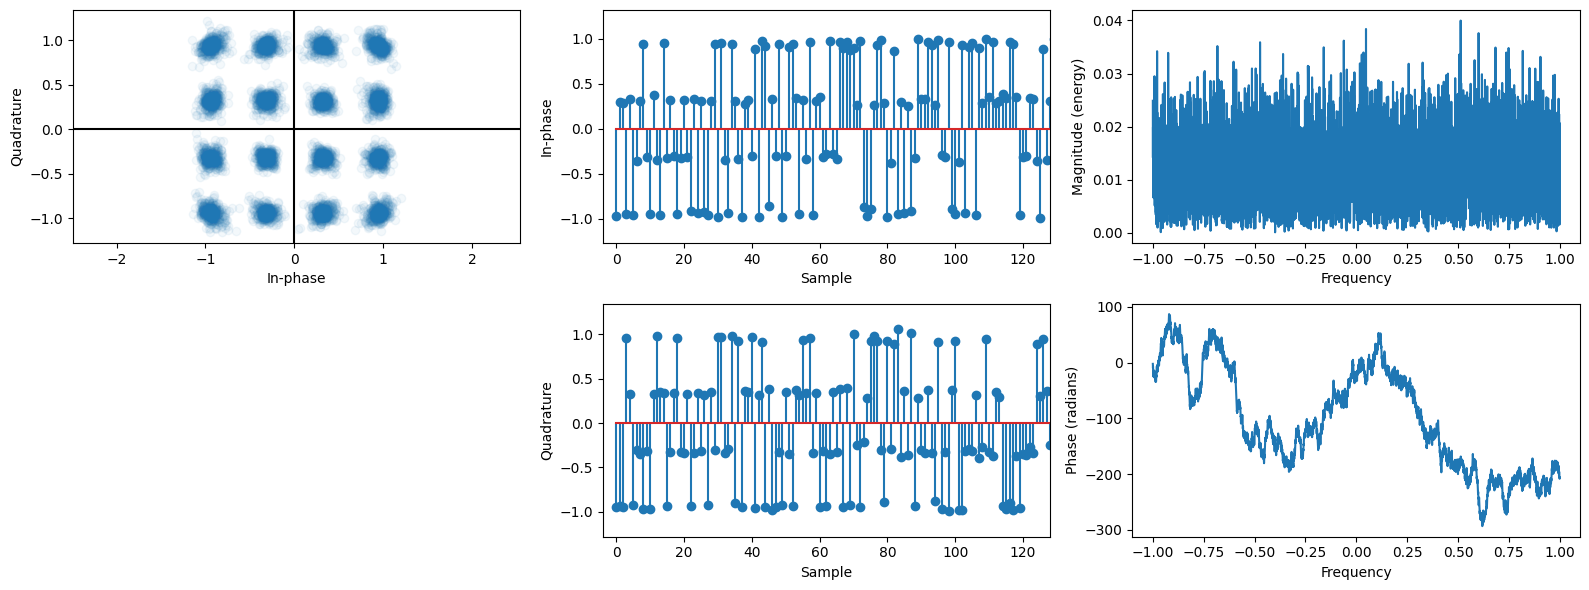

In [161]:
for i in range(8):
    plot_signal(rx_aeq[i * 240_000 : i * 240_000 + 10_000])

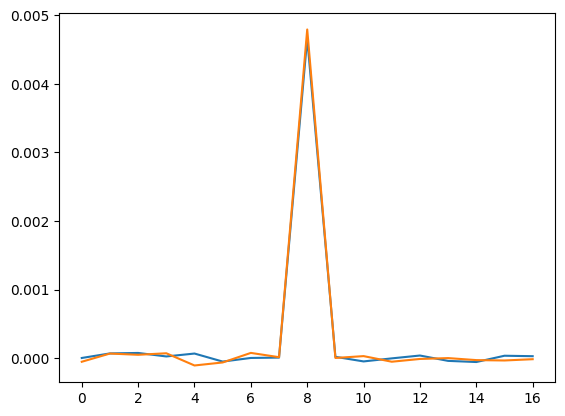

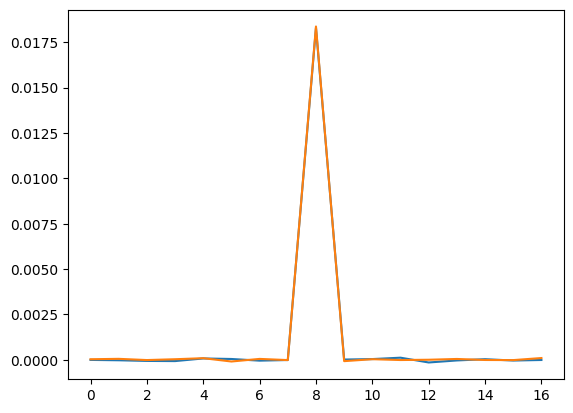

In [162]:
plt.plot(aeq.w11.real)
plt.plot(-np.conj(aeq.w22).real)
plt.show()
plt.plot(aeq.w11.imag)
plt.plot(-np.conj(aeq.w22).imag)
plt.show()

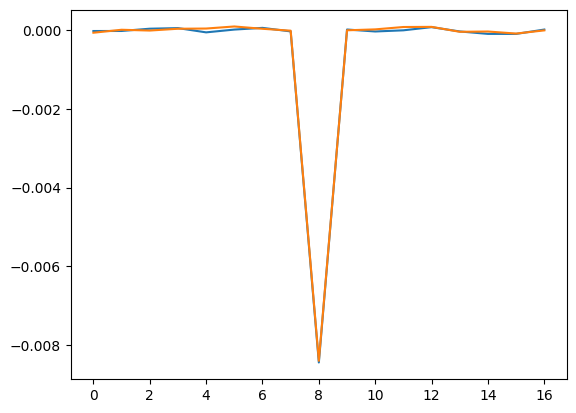

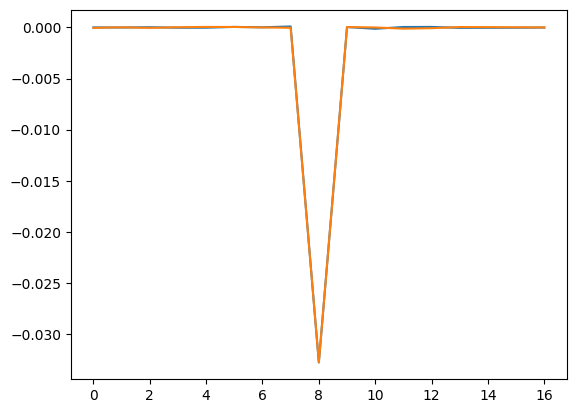

In [163]:
plt.plot(aeq.w21.real)
plt.plot(np.conj(aeq.w12).real)
plt.show()
plt.plot(aeq.w21.imag)
plt.plot(np.conj(aeq.w12).imag)
plt.show()

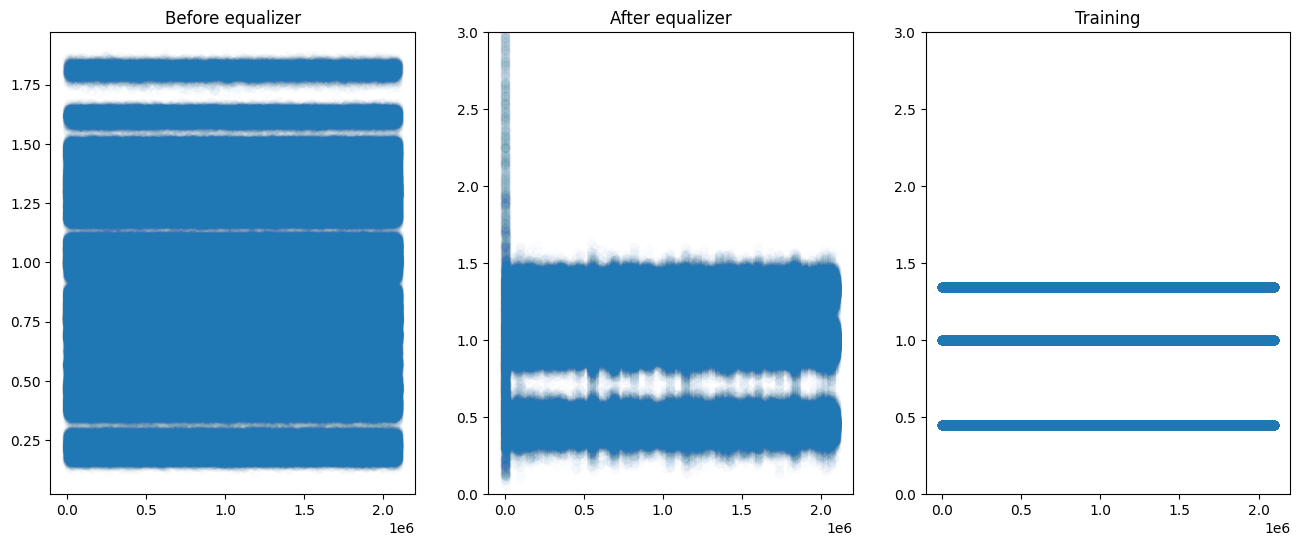

In [164]:
from utils import has_one_polarization, normalize_power

fig, axs = plt.subplots(1, 3, figsize=(16,6))
assert has_one_polarization(rx_pf)
axs[0].scatter(range(rx_pf.size), np.abs(normalize_power(rx_pf)), alpha=0.01)
axs[0].set_title("Before equalizer")
assert has_one_polarization(rx_aeq)
axs[1].scatter(range(rx_aeq.size), np.abs(rx_aeq), alpha=0.01)
axs[1].set_title("After equalizer")
axs[1].set_ylim(0, 3)
assert has_one_polarization(tx_mod)
axs[2].scatter(range(tx_mod.size), np.abs(tx_mod), alpha=0.01)
axs[2].set_title("Training")
axs[2].set_ylim(*axs[1].get_ylim())

plt.show()

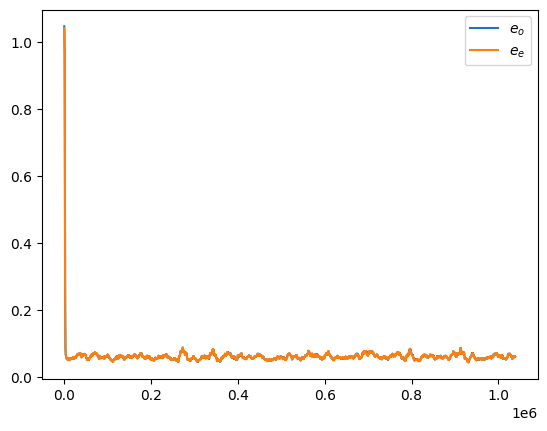

In [165]:
def ma(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.plot(ma(np.abs(aeq.e_o_log), 10_000), label="$e_o$")
plt.plot(ma(np.abs(aeq.e_e_log), 10_000), label="$e_e$")
plt.legend()
# plt.xlim(0, 1_000)
plt.show()

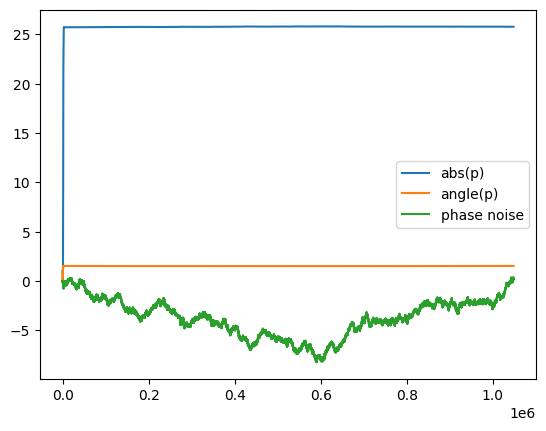

In [166]:
plt.plot(np.abs(aeq.p_log), label="abs(p)")
plt.plot(np.unwrap(np.angle(aeq.p_log)), label="angle(p)")
assert laser.last_noise is not None
plt.plot(-np.unwrap(laser.last_noise[::32]), label="phase noise")
plt.legend()
plt.show()

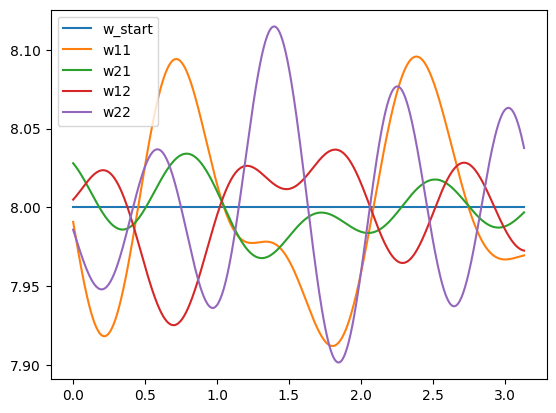

In [167]:
import scipy.signal

w_start = np.zeros(17, dtype=np.cdouble)
w_start[17 // 2] = 1
plt.plot(*scipy.signal.group_delay((w_start, 1)), label="w_start")
plt.plot(*scipy.signal.group_delay((aeq.w11, 1)), label="w11")
plt.plot(*scipy.signal.group_delay((aeq.w21, 1)), label="w21")
plt.plot(*scipy.signal.group_delay((aeq.w12, 1)), label="w12")
plt.plot(*scipy.signal.group_delay((aeq.w22, 1)), label="w22")
plt.legend()
# plt.savefig("2023-03-01 Alamouti AdEq group delays.pdf")

In [168]:
print(np.mean(aeq.e_o_log))
print(np.mean(aeq.e_e_log))

(0.00018535804483127356+0.00015175337668989932j)
(7.531265192511613e-05+0.00034194845375531404j)


In [169]:
rx_demod = Demodulator16QAM()(rx_aeq)

In [170]:
def print_ber(a, b) -> None:
    assert a.shape == b.shape
    print(np.count_nonzero(a ^ b) / a.size)

In [171]:
print(rx_demod.shape)
print(data.shape)

(8388320,)
(8388320,)


In [172]:
print_ber(rx_demod, data)

0.0013524758235260457


In [173]:
import scipy.signal
from numpy.typing import NDArray


def find_lag(ref: NDArray[np.bool_], sig: NDArray[np.bool_]) -> int:
    corr = scipy.signal.correlate(ref.astype(np.float64), sig.astype(np.float64))
    lags = scipy.signal.correlation_lags(ref.size, sig.size)

    lag = lags[np.argmax(corr)]

    return lag


def compare_streams(
    ref: NDArray[np.bool_], sig: NDArray[np.bool_]
) -> tuple[float, float]:
    # Ensure lag + y.size < x.size.
    sig_slice = sig[:-10_000] if sig.size > ref.size - 10_000 else sig

    # Both polarizations carry the same data, but one stream is delayed by 98
    # symbols (196 bits). Unfortunately, this isn't always the case.
    lag = find_lag(ref, sig_slice)
    assert lag >= 0

    ref_slice = ref[lag : lag + sig_slice.size]
    assert ref_slice.size == sig_slice.size

    ber = np.count_nonzero(ref_slice ^ sig_slice) / ref_slice.size

    return lag, ber

In [174]:
compare_streams(data, rx_demod[400_000:])

(400000, 7.93658741762974e-05)

In [175]:
# compare_streams(data[-20_000:], rx_demod)
compare_streams(rx_demod, data[-20_000:])

(8368320, 0.0)